### 必要なライブラリのインストール

In [1]:
!pip install -q transformers==4.4.0
!pip install -q pytorch_lightning
!pip install -q torchmetrics

     |████████████████████████████████| 2.1 MB 7.9 MB/s 
     |████████████████████████████████| 880 kB 65.5 MB/s 
     |████████████████████████████████| 3.3 MB 46.8 MB/s 
     |████████████████████████████████| 585 kB 6.9 MB/s 
     |████████████████████████████████| 419 kB 29.9 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
     |████████████████████████████████| 140 kB 77.7 MB/s 
     |████████████████████████████████| 1.1 MB 53.0 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 71.0 MB/s 
     |████████████████████████████████| 144 kB 73.8 MB/s 


In [2]:
!pip install --upgrade torchtext==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 5.7 MB/s 
     |████████████████████████████████| 804.1 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy.data import Field, TabularDataset, BucketIterator #legacy.data と変更してください  
import pytorch_lightning as pl
import transformers

import torchmetrics
from torchmetrics.functional import accuracy

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:
import torchtext
print(torch.__version__)
print(torchtext.__version__)
print(pl.__version__)

1.8.1+cu102
0.9.1
1.6.4


In [5]:
# 202110 時点 Google Colaboratory では Tesla K80 がメイン GPU になりました。  
torch.cuda.get_device_name(0)

'Tesla T4'

In [7]:
!unzip -q text.zip

### データセットの作成

In [8]:
import os

pl.seed_everything(0)

# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]

# ID → カテゴリ
id2cat = dict(zip(list(range(len(categories))), categories))
# カテゴリ → ID 
cat2id = dict(zip(categories, list(range(len(categories)))))
print('id2cat:', id2cat)
print('cat2id:', cat2id)

Global seed set to 0


id2cat: {0: 'sports-watch', 1: 'kaden-channel', 2: 'movie-enter', 3: 'it-life-hack', 4: 'topic-news', 5: 'livedoor-homme', 6: 'smax', 7: 'dokujo-tsushin', 8: 'peachy'}
cat2id: {'sports-watch': 0, 'kaden-channel': 1, 'movie-enter': 2, 'it-life-hack': 3, 'topic-news': 4, 'livedoor-homme': 5, 'smax': 6, 'dokujo-tsushin': 7, 'peachy': 8}


In [9]:
from glob import glob

# 各ファイルへのパスを取得
for cat in categories[:3]:
    path = "text/" + cat + "/*.txt"
    files = sorted(glob(path))
    print(files[3])

text/sports-watch/sports-watch-4604621.txt
text/kaden-channel/kaden-channel-5775172.txt
text/movie-enter/movie-enter-5840524.txt


In [10]:
import linecache

# 各テキストデータの３行目（タイトル）のみを取得
for text_name in files[0:10]:
    title = linecache.getline(text_name, 3)
    print(title)

原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を

インタビュー：宮崎あおい＆堺雅人「一緒にいるのが当たり前」

「さわお」×「わさお」が奇跡の対面

上島竜兵が「出川には負けない！」と極秘実験でイケメンマッチョに変身

吉澤ひとみが新チーム結成「今、大事にしなきゃいけない人」

2012年に映像革命が起こる、『ロード・オブ・ザ・リング』の前章『ホビット』の公開が決定

ヴェネチア国際映画祭で染谷将太、二階堂ふみに大歓声！　園子温監督作『ヒミズ』に金獅子賞の期待膨らむ 

『バイオハザード』を超えた、『三銃士』がドイツで初登場1位を獲得

日本最果ての地で誕生した映画が『しんぼる』『となりのトトロ』に続くプレミア上映決定

「好きよ、抱いて！」、映画『モテキ』着信ボイスを無料配信



1. 変数 `categories` を元に `text` フォルダ内のテキストデータ全てを読み込む
    - テキストは各テキストファイルの 3 行目のタイトルのみ
2. `\n` のみ除去
3. データフレームに格納
    - カラム → `title` : テキストデータのタイトル / `category` :  テキストデータのカテゴリ名
4. データを `.sample` でシャッフルすること
5. データセット作成後、`category` 列を参照して、カテゴリ → ID に変換
    - `title` : テキストデータ / `category` : カテゴリ / `category_id` : カテゴリの ID

In [11]:
import pandas as pd

# データフレームの用意
datasets = pd.DataFrame(columns=["title", "category"])

In [12]:
import re

# 先程までの処理をまとめてデータフレームに格納
for cat in categories:
    path = "text/" + cat + "/*.txt"
    files = sorted(glob(path))
    for text_name in files:
        title = linecache.getline(text_name, 3)
        cleaned_title = re.sub('\n', '', title)
        s = pd.Series([cleaned_title, cat], index=datasets.columns)
        datasets = datasets.append(s, ignore_index=True)

# データをシャッフル
livedoor_data = datasets.sample(frac=1).reset_index(drop=True)

# カテゴリ → ID を適用
livedoor_data['category_id'] = livedoor_data['category'].map(cat2id)
livedoor_data.head(3)

,title,category,category_id
0,友を失うその前に！？ ビジネススキルの意外なる盲点,livedoor-homme,5
1,【終了しました】自然のちからを肌に届ける「草花木果」で、つるんとなめらか、透明肌へ。セットで...,peachy,8
2,独女的映画レビュー vol.3 『カンバセーションズ』,dokujo-tsushin,7


In [13]:
livedoor_data = livedoor_data[['title', 'category_id']]
livedoor_data.head(3)

,title,category_id
0,友を失うその前に！？ ビジネススキルの意外なる盲点,5
1,【終了しました】自然のちからを肌に届ける「草花木果」で、つるんとなめらか、透明肌へ。セットで...,8
2,独女的映画レビュー vol.3 『カンバセーションズ』,7


### データの分割

In [14]:
# 学習用データとテストデータに分ける
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(livedoor_data, test_size=0.2, random_state=0)
train_df, val_df = train_test_split(train_val_df, test_size=0.3, random_state=0)

print("学習用データのサイズ", train_df.shape)
print("検証用データのサイズ", val_df.shape)
print("テスト用データのサイズ", test_df.shape)

学習用データのサイズ (4130, 2)
検証用データのサイズ (1770, 2)
テスト用データのサイズ (1476, 2)


In [15]:
# csvファイルとして保存する
train_df.to_csv('train.csv', header=None, index=None)
val_df.to_csv('val.csv', header=None, index=None)
test_df.to_csv('test.csv', header=None, index=None)

### BERT 用分かち書き（Tokenizer）の用意

In [16]:
!pip install -q fugashi
!pip install -q ipadic

     |████████████████████████████████| 568 kB 8.0 MB/s 
     |████████████████████████████████| 13.4 MB 8.2 MB/s 


In [17]:
# 分かち書き用の tokenizer
from transformers import BertJapaneseTokenizer

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

### Tokenizer の結果を確認

In [18]:
# 分かち書き用の tokenizer
text = list(train_df['title'])[0]

# return_tensors に pt(PyTorch) を選択
wakati_ids = tokenizer.encode(text, return_tensors='pt')

print('各単語に振られている id：', wakati_ids)
print('id のサイズ：', wakati_ids.size())

各単語に振られている id： tensor([[   2, 7319,   14,  107, 8896, 2935, 2910,   15,   10, 4027,    5,   36,
         8065, 3700,   38,   14, 4459,    7,  737,   80, 1515, 9680, 4459, 9594,
            3]])
id のサイズ： torch.Size([1, 25])


In [19]:
text

'コンテンツが高すぎる？\u3000スタートしたばかりの「もっとTV」が話題にならない理由【話題】'

In [20]:
# 分かち書き後の文
print('分かち書きした単語：',tokenizer.convert_ids_to_tokens(wakati_ids[0]))

分かち書きした単語： ['[CLS]', 'コンテンツ', 'が', '高', 'すぎる', '?', 'スタート', 'し', 'た', 'ばかり', 'の', '「', 'もっと', 'TV', '」', 'が', '話題', 'に', 'なら', 'ない', '理由', '【', '話題', '】', '[SEP]']


### 分かち書き後の単語の最大長を確認

In [21]:
title_length = livedoor_data['title'].map(tokenizer.encode).map(len)

print(max(title_length))

76


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


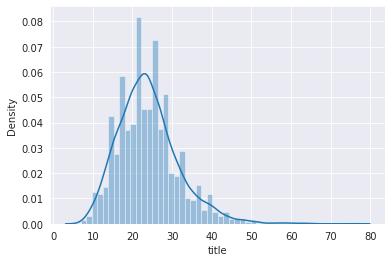

In [24]:
# ヒストグラムを可視化
import seaborn as sns
sns.set_style('darkgrid')

sns.distplot(title_length);

### BERT 用 Tokenizer と TorchText を使用したデータセットの作成

In [25]:
def bert_tokenizer(text):
    return tokenizer.encode(text, return_tensors='pt')[0]

In [26]:
# Tokenizer の pad トークン ID の取得
pad_token_idx = tokenizer.pad_token_id
print(pad_token_idx)

0


In [27]:
# Field の設定
TEXT = Field(
    tokenize=bert_tokenizer, 
    use_vocab=False,
    batch_first=True, 
    pad_token=pad_token_idx)

LABEL = Field(
    sequential=False, 
    use_vocab=False,
    is_target=True)

In [28]:
# TorchText TabularDataset を使用した読み込み
train_data, val_data, test_data = TabularDataset.splits(
    path='',
    train='train.csv',
    validation = 'val.csv',
    test='test.csv',
    format='csv',
    fields=[('x', TEXT), ('t', LABEL)])

### DataLoader の作成

In [29]:
pl.seed_everything(0)

batch_size=32

train_loader = BucketIterator(train_data, batch_size, shuffle=True)
val_loader = BucketIterator(val_data, batch_size)
test_loader = BucketIterator(test_data, batch_size)

Global seed set to 0


In [30]:
# 中身を確認
batch = next(iter(train_loader))

print('train_iter 内の最初の文章（ID）：', batch.x[0])
print("長さ：", len(batch.x[0]))  
print("ラベル：", batch.t[0])
print('文章のカテゴリ：', id2cat[int(batch.t[0])])

print('含まれる文字列：', tokenizer.convert_ids_to_tokens(batch.x[0]))

train_iter 内の最初の文章（ID）： tensor([    2,  5366, 11916,     7, 15528, 28457,  1216, 26712,     5,  2868,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
長さ： 34
ラベル： tensor(0)
文章のカテゴリ： sports-watch
含まれる文字列： ['[CLS]', '底', '##抜け', 'に', '可愛', '##い', '国内', '無敵', 'の', 'チャンピオン', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [31]:
from transformers import BertModel

# BERT のモデル構造を確認
bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

print(bert.config)

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.4.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



In [32]:
sample_ids = batch.x[0].unsqueeze(0)

bert_out = bert(sample_ids, output_attentions=True)

len(bert_out)

3

In [33]:
# BERT の出力 1 sequence_output
# ここに格納されているのは、BERT により入力された系列が埋め込み表現に変換された値です。
print('BERT の分散表現:', bert_out[0])
print('分散表現の形：', bert_out[0].shape)

BERT の分散表現: tensor([[[-0.7664,  0.3372,  0.0734,  ..., -0.3660, -1.4090,  0.1561],
         [-0.6048,  0.4757,  0.0143,  ..., -0.6551, -1.4973,  0.2622],
         [-0.5128,  0.5648, -0.0591,  ..., -0.1275, -0.9531,  0.4290],
         ...,
         [-0.6346,  0.3120,  0.2112,  ..., -0.2405, -1.4402,  0.2512],
         [-0.6527,  0.3371,  0.1984,  ..., -0.1991, -1.4577,  0.2344],
         [-0.6527,  0.3539,  0.2050,  ..., -0.1626, -1.4910,  0.2146]]],
       grad_fn=<NativeLayerNormBackward>)
分散表現の形： torch.Size([1, 34, 768])


In [34]:
# BERT の出力 2 pooled_output
# [CLS] トークンに対応するベクトルをさらに線形写像したものが格納されています。
print(bert_out[1])
print(bert_out[1].shape)

tensor([[ 7.7604e-01, -4.7069e-01, -2.5753e-01, -1.6704e-01,  1.2131e-01,
          9.9813e-01, -4.1677e-01,  6.3521e-02,  1.2830e-01, -7.2432e-02,
          1.7502e-01,  2.8855e-01,  4.4259e-02,  4.4484e-01,  2.3860e-01,
         -3.4121e-01,  2.7969e-01, -2.4965e-02,  2.9459e-01,  1.7401e-03,
         -1.0727e-01,  2.8687e-01, -2.6278e-02,  9.9540e-01,  9.9941e-01,
          4.8138e-01,  3.4808e-02, -5.1303e-01,  9.9840e-01,  6.4132e-01,
          5.3104e-01,  1.4260e-01,  5.4266e-02,  2.7531e-02,  7.8514e-02,
         -8.3245e-02,  7.2229e-01,  1.3809e-01, -9.4432e-03, -2.3540e-01,
         -8.1260e-02, -9.2222e-01, -8.3041e-01, -2.6173e-02,  5.0509e-01,
          1.8540e-01, -1.7790e-01, -5.2040e-01,  2.9715e-01,  1.4456e-01,
         -2.7709e-01,  2.2371e-01, -9.9959e-02, -9.9737e-01, -1.0351e-01,
          5.9449e-01,  5.6427e-03, -3.4658e-01, -7.4529e-02,  9.9889e-01,
          9.7608e-01, -3.4261e-01,  7.7707e-02,  3.7855e-01, -5.3713e-01,
          6.6663e-01,  1.0126e-01,  4.

In [35]:
# BERT の出力 2 Attention Weight
# BERT 内で使用されている Attention Weight が格納されています。
print(len(bert_out[2]))

12


In [36]:
# BERT 最終層の Attenton Weight を出力
print('最後の　Bertlayer の　Attention Weight：', bert_out[2][-1])
print(bert_out[2][-1].shape)

最後の　Bertlayer の　Attention Weight： tensor([[[[0.0171, 0.0095, 0.1053,  ..., 0.0083, 0.0084, 0.0093],
          [0.0102, 0.0136, 0.1909,  ..., 0.0034, 0.0029, 0.0029],
          [0.0081, 0.0103, 0.1295,  ..., 0.0037, 0.0033, 0.0033],
          ...,
          [0.0066, 0.0017, 0.0397,  ..., 0.0154, 0.0164, 0.0158],
          [0.0074, 0.0018, 0.0401,  ..., 0.0143, 0.0161, 0.0164],
          [0.0083, 0.0020, 0.0420,  ..., 0.0118, 0.0137, 0.0149]],

         [[0.0383, 0.0191, 0.1478,  ..., 0.0161, 0.0158, 0.0163],
          [0.0200, 0.0384, 0.3947,  ..., 0.0043, 0.0036, 0.0036],
          [0.0237, 0.0342, 0.2659,  ..., 0.0076, 0.0063, 0.0057],
          ...,
          [0.0282, 0.0074, 0.0750,  ..., 0.0527, 0.0545, 0.0492],
          [0.0301, 0.0070, 0.0729,  ..., 0.0451, 0.0511, 0.0517],
          [0.0330, 0.0073, 0.0739,  ..., 0.0366, 0.0431, 0.0474]],

         [[0.0281, 0.0262, 0.0622,  ..., 0.0240, 0.0246, 0.0256],
          [0.0252, 0.0308, 0.1021,  ..., 0.0231, 0.0235, 0.0246],
        

### ネットワークの定義

In [37]:
class BertClassifier(pl.LightningModule):
    def __init__(self, n_output=9):
        super().__init__()
        self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
        d_model = self.bert.pooler.dense.in_features

        # BERTの隠れ層の次元数は768, ニュース記事のカテゴリ数が9
        self.fc = nn.Linear(d_model, n_output)

        # Fine tuning の設定
        # 全てを勾配計算 False に設定
        for param in self.parameters():
            param.requires_grad = False
            
        # Bert の最後の Layer を勾配計算ありに変更
        for param in self.bert.encoder.layer[-1].parameters():
            param.requires_grad = True
            
        # Linear を勾配計算ありに変更
        for param in self.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        bert_out = self.bert(x, output_attentions=True)
        # [CLS] に対する分散表現のみ取得
        h = bert_out[0][:,0,:]
        # h = bert_out[1]
        h = self.fc(h)
        return h, bert_out[2]

    def training_step(self, batch, batch_idx):
        x, t = batch.x, batch.t
        # forward の出力は out と attentions の tuple
        y = self(x)[0]
        loss = F.cross_entropy(y, t)

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch.x, batch.t
        # forward の出力は out と attentions の tuple
        y = self(x)[0]
        loss = F.cross_entropy(y, t)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch.x, batch.t
        # forward の出力は out と attentions の tuple
        y = self(x)[0]
        loss = F.cross_entropy(y, t)

        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # 学習率を分ける
        optimizer = transformers.AdamW([
                                        {'params': self.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
                                        {'params': self.fc.parameters(), 'lr': 3e-5}
        ])
        return optimizer

### 学習

In [38]:
from pytorch_lightning.loggers import CSVLogger

In [ ]:
# 乱数シードの固定
pl.seed_everything(0)

# インスタンス化
net = BertClassifier()

logger = CSVLogger(save_dir="logs", name='my_exp')

trainer = pl.Trainer(max_epochs=4, gpus=1, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)


Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/my_exp
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
result = trainer.test(dataloaders=test_loader)